Train size: 80367, Test size: 19633
Number of users in train set: 943, Number of users in test set: 943
Number of items in train set: 1615, Number of items in test set: 1499

Epoch 1/10
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 6.6718 - sparse_categorical_accuracy: 0.0072 - val_loss: 5.8767 - val_sparse_categorical_accuracy: 0.0159

Epoch 2/10
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.8683 - sparse_categorical_accuracy: 0.0144 - val_loss: 5.7694 - val_sparse_categorical_accuracy: 0.0138

Epoch 3/10
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.7389 - sparse_categorical_accuracy: 0.0166 - val_loss: 5.7207 - val_sparse_categorical_accuracy: 0.0175

Epoch 4/10
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.6459 - sparse_categorical_accuracy: 0.0190 - val_loss: 5.6775 - val_sparse_categorical_accuracy: 0.0180

Epoch 5/10
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.5736 - sparse_categorical_accuracy: 0.0202 - val_loss: 5.6666 - val_sparse_categ

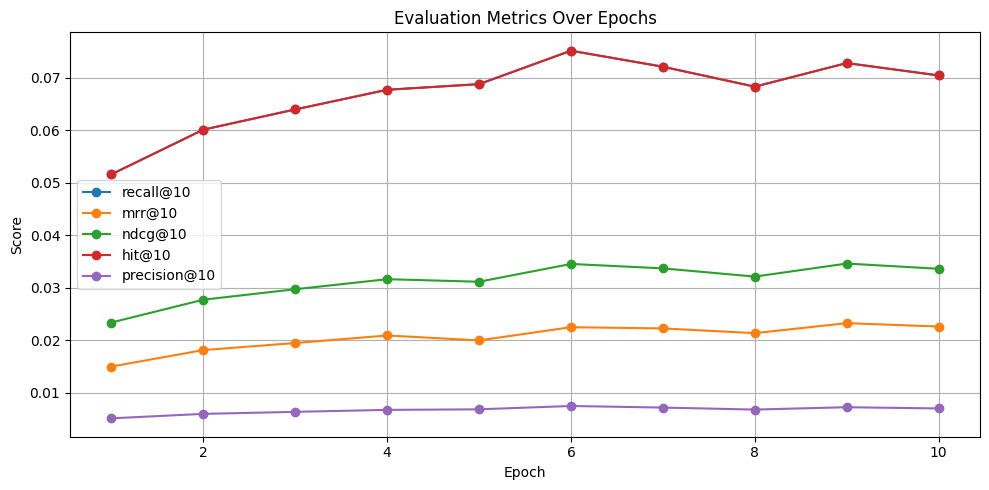


User ID: 1
Recent Sequence: ['Four Rooms (1995)', 'D3: The Mighty Ducks (1996)', 'While You Were Sleeping (1995)', 'Nadja (1994)', 'Net, The (1995)', 'Homeward Bound: The Incredible Journey (1993)', 'Last of the Mohicans, The (1992)', "Carlito's Way (1993)", 'Free Willy (1993)', 'Die Hard 2 (1990)', 'Santa Clause, The (1994)', 'Young Guns (1988)', 'Love Bug, The (1969)', 'Brother Minister: The Assassination of Malcolm X (1994)', 'Bedknobs and Broomsticks (1971)', 'Legends of the Fall (1994)', 'Outbreak (1995)', 'Star Trek: The Wrath of Khan (1982)', 'Dead Man Walking (1995)', 'Wrong Trousers, The (1993)', '12 Angry Men (1957)', 'Searching for Bobby Fischer (1993)', 'French Twist (Gazon maudit) (1995)', 'Remains of the Day, The (1993)', 'Fargo (1996)', "Monty Python's Life of Brian (1979)", 'Dolores Claiborne (1994)', 'Star Trek: First Contact (1996)', 'Contact (1997)', 'Kull the Conqueror (1997)', "My Best Friend's Wedding (1997)", 'Good Will Hunting (1997)', 'Starship Troopers (1997)

In [1]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Load Data
url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Preprocess Data
df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)
df = df.sort_values(by=['user_id', 'timestamp'])

# Create item mappings
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}

# Train-test split per user
def user_based_split(data, test_ratio=0.2):
    train_rows, test_rows = [], []
    for _, group in data.groupby('user_id'):
        n_test = int(len(group) * test_ratio)
        group_sorted = group.sort_values(by='timestamp')
        if n_test > 0:
            test_rows.append(group_sorted.tail(n_test))
            train_rows.append(group_sorted.head(len(group) - n_test))
        else:
            train_rows.append(group_sorted)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)
    return train_df, test_df

train_df, test_df = user_based_split(df, test_ratio=0.2)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 50

def create_sequences(sequences):
    input_seqs, labels = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            input_seq = seq[max(0, i - max_seq_len):i]
            label = seq[i]
            input_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
            input_seqs.append(input_seq)
            labels.append(label)
    return np.array(input_seqs, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = create_sequences(train_sequences['item_id'].tolist())
test_input, test_labels = create_sequences(test_sequences['item_id'].tolist())

class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=128, num_layers=2, dropout_rate=0.2):
        super(xLSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.lstm_layers = [
            tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=dropout_rate)
            for _ in range(num_layers - 1)
        ] + [
            tf.keras.layers.LSTM(hidden_units, return_sequences=False, dropout=dropout_rate)
        ]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        for lstm_layer in self.lstm_layers:
            x = lstm_layer(x, training=training)
        logits = self.dense(x)
        return logits

model = xLSTM(vocab_size=len(item_to_idx) + 1, hidden_units=128, num_layers=2, dropout_rate=0.2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

def evaluate_sequence_prediction(model, test_sequences, top_k=10):
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    total_preds = 0

    for seq in test_sequences['item_id'].tolist():
        for i in range(1, len(seq)):
            input_seq = seq[max(0, i - max_seq_len):i]
            target = seq[i]
            input_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
            input_seq = np.array([input_seq])

            logits = model(input_seq, training=False).numpy()[0]
            top_k_preds = np.argsort(logits)[::-1][:top_k]

            if target in top_k_preds:
                hit += 1
                recall += 1
                precision += 1 / top_k
                rank = list(top_k_preds).index(target)
                mrr += 1 / (rank + 1)
                dcg = 1 / np.log2(rank + 2)
            else:
                dcg = 0

            idcg = 1 / np.log2(2)
            ndcg += dcg / idcg
            total_preds += 1

    metrics_history["recall@10"].append(recall / total_preds)
    metrics_history["mrr@10"].append(mrr / total_preds)
    metrics_history["ndcg@10"].append(ndcg / total_preds)
    metrics_history["hit@10"].append(hit / total_preds)
    metrics_history["precision@10"].append(precision / total_preds)

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=64, verbose=1)
    evaluate_sequence_prediction(model, test_sequences, top_k=10)

# Plot after all epochs
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def explain_top_prediction_for_users(model, sequences, user_ids, top_k=1):
    for uid in user_ids:
        user_row = sequences[sequences['user_id'] == uid]
        if user_row.empty:
            continue
        sequence = user_row.iloc[0]['item_id']
        input_seq = sequence[-max_seq_len:]
        padded_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
        input_array = np.array([padded_seq])
        logits = model(input_array, training=False).numpy()[0]
        top_k_preds = np.argsort(logits)[-top_k:][::-1]

        print(f"\nUser ID: {uid}")
        print(f"Recent Sequence: {[idx_to_title.get(i, 'UNK') for i in input_seq if i > 0]}")

        for rank, idx in enumerate(top_k_preds):
            item_id = idx_to_item.get(idx, 'UNK')
            title = idx_to_title.get(idx, 'UNK')
            print(f"Prediction #{rank+1}: {title} (Item ID: {item_id}, Logit Score: {logits[idx]:.4f})")

explain_top_prediction_for_users(model, test_sequences, user_ids=test_sequences['user_id'].head(5).tolist(), top_k=1)
print("Next-item sequence prediction training and evaluation completed.")

**1. Datasets: ML-100K dataset**

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
99988,421,498,4,892241344,38,F,programmer,55105,"African Queen, The (1951)",01-Jan-1951,...,0,0,0,0,0,1,0,0,1,0
99989,495,1091,4,888637503,29,M,engineer,03052,Pete's Dragon (1977),01-Jan-1977,...,0,0,0,1,0,0,0,0,0,0
99990,806,421,4,882388897,27,M,marketing,11217,William Shakespeare's Romeo and Juliet (1996),25-Oct-1996,...,0,0,0,0,0,1,0,0,0,0
99991,676,538,4,892685437,30,M,programmer,32712,Anastasia (1997),01-Jan-1997,...,0,0,0,1,0,0,0,0,0,0
99992,721,262,3,877137285,24,F,entertainment,11238,In the Company of Men (1997),01-Aug-1997,...,0,0,0,0,0,0,0,0,0,0
99993,913,209,2,881367150,27,M,student,76201,This Is Spinal Tap (1984),01-Jan-1984,...,0,0,0,1,0,0,0,0,0,0
99994,378,78,3,880056976,35,M,student,02859,Free Willy (1993),01-Jan-1993,...,0,0,0,0,0,0,0,0,0,0
99995,880,476,3,880175444,13,M,student,83702,"First Wives Club, The (1996)",14-Sep-1996,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,36,F,administrator,44265,Back to the Future (1985),01-Jan-1985,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,874795795,21,M,student,95064,Sliver (1993),01-Jan-1993,...,0,0,0,0,0,0,0,1,0,0


Train size: 80000, Test size: 20000
Number of users in train set: 751, Number of users in test set: 301
Number of items in train set: 1616, Number of items in test set: 1448
Number of cold-start users (only in test set): 192
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 688ms/step - loss: 7.2556 - sparse_categorical_accuracy: 2.3289e-04 - val_loss: 6.7444 - val_sparse_categorical_accuracy: 2.8269e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step
User 0 - True: {'185'}, Pred: ['1', '405', '181', '100', '7', '204', '288', '216', '275', '237']
User 1 - True: {'473', '928', '185', '687', '696', '284', '210', '286', '405'}, Pred: ['1', '405', '181', '100', '7', '204', '288', '216', '275', '237']
User 2 - True: {'544', '1074', '284', '210', '255'}, Pred: ['1', '405', '181', '100', '7', '204', '288', '216', '275', '237']
User 3 - True: {'230', '234', '831', '182', '176', '729', '770', '127', '367', '148', '746', '568', '11', '373', '260', '412', '1207', '824', '678', '1469', '300', '761', '64', '23', 

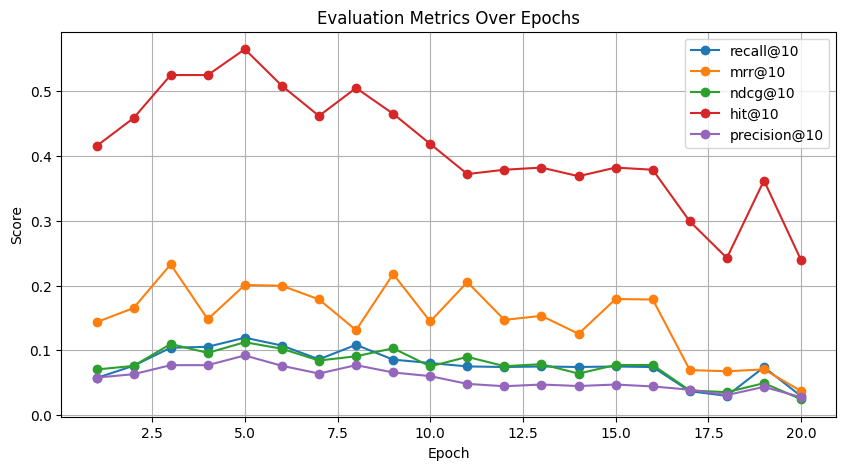

Training Completed! Metrics history saved to metrics_history.json


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Load Data
url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Preprocess Data
df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)

display(df.tail(12))

df = df.sort_values(by=['timestamp'])

# Create item mappings
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows()}

def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

# Identify cold-start users (users present only in test set)
cold_start_users = set(test_df['user_id']) - set(train_df['user_id'])
print(f"Number of cold-start users (only in test set): {len(cold_start_users)}")
train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 512

def mask_items(sequences, mask_prob=0.2):
    masked_sequences, labels = [], []
    for seq in sequences:
        masked_seq = seq[:]
        label = [-1] * len(seq)
        for i in range(len(seq)):
            if np.random.rand() < mask_prob:
                label[i] = masked_seq[i]
                masked_seq[i] = 0

        if all(l == -1 for l in label):
            random_idx = np.random.randint(len(seq))
            label[random_idx] = masked_seq[random_idx]
            masked_seq[random_idx] = 0

        label = [l if l != -1 else 0 for l in label]
        masked_seq = masked_seq[:max_seq_len] + [0] * (max_seq_len - len(masked_seq))
        label = label[:max_seq_len] + [0] * (max_seq_len - len(label))

        masked_sequences.append(masked_seq)
        labels.append(label)
    return np.array(masked_sequences, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = mask_items(train_sequences['item_id'].tolist())
test_input, test_labels = mask_items(test_sequences['item_id'].tolist())

class MaskedLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)


class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=128, num_layers=2, dropout_rate=0.2):
        super(xLSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.lstm_layers = [
            tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        for lstm_layer in self.lstm_layers:
            x = lstm_layer(x, training=training)
        logits = self.dense(x)
        return logits

model = xLSTM(vocab_size=len(item_to_idx) + 1, hidden_units=128, num_layers=2, dropout_rate=0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=MaskedLoss(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

def evaluate_metrics(model, test_input, test_labels, top_k=10):
    predictions = model.predict(test_input)
    logits = predictions[:, -1, :]  # Last position logits for all users
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    num_samples = len(test_labels)

    for i in range(num_samples):
        # Convert true item indices to actual item IDs
        true_items = set([idx_to_item[idx] for idx in np.where(test_labels[i] > 0)[0] if idx in idx_to_item])

        # Get top-K predictions, excluding seen items
        pred_items = [
            idx_to_item[int(idx)] for idx in np.argsort(logits[i])[::-1]
            if int(idx) in idx_to_item and idx not in true_items
        ][:top_k]

        pred_items_set = set(pred_items)

        # Debugging: Print actual values
        if i < 4:
            print(f"User {i} - True: {true_items}, Pred: {pred_items}")

        # Compute Metrics
        correct_preds = len(true_items & pred_items_set)
        recall += correct_preds / len(true_items) if len(true_items) > 0 else 0

        for rank, item in enumerate(pred_items, start=1):
            if item in true_items:
                mrr += 1 / rank
                break

        dcg = sum([(1 / np.log2(rank + 2)) if pred_items and pred_items[rank] in true_items else 0 for rank in range(min(len(pred_items), top_k))])
        idcg = sum([1 / np.log2(rank + 2) for rank in range(min(len(true_items), top_k))])
        ndcg += dcg / idcg if idcg > 0 else 0

        hit += int(correct_preds > 0) if pred_items else 0
        precision += correct_preds / top_k if pred_items else 0

    return recall / num_samples, mrr / num_samples, ndcg / num_samples, hit / num_samples, precision / num_samples

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

for epoch in range(20):
    print(f"Epoch {epoch+1}/20")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=16, verbose=1)
    recall, mrr, ndcg, hit, precision = evaluate_metrics(model, test_input, test_labels)
    print(f"Metrics at epoch {epoch+1}:")
    print(f"Recall@10: {recall:.8f}, MRR@10: {mrr:.8f}, NDCG@10: {ndcg:.8f}, Hit@10: {hit:.8f}, Precision@10: {precision:.8f}")
    metrics_history["recall@10"].append(recall)
    metrics_history["mrr@10"].append(mrr)
    metrics_history["ndcg@10"].append(ndcg)
    metrics_history["hit@10"].append(hit)
    metrics_history["precision@10"].append(precision)
    print(metrics_history)

def recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    top_indices = [idx for idx in np.argsort(logits)[::-1] if idx not in watched_items_set][:top_k]

    print(f"Top Recommended Items for User ID {user_id}:")
    recommended_items = []

    for i, idx in enumerate(top_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return recommended_items

def least_recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    bottom_indices = [idx for idx in np.argsort(logits) if idx not in watched_items_set][:top_k]

    print(f"Least Recommended Items for User ID {user_id}:")
    least_recommended_items = []

    for i, idx in enumerate(bottom_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            least_recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return least_recommended_items

recommend_items(user_id=1, top_k=10)
print("  ")
recommend_items(user_id=2, top_k=10)

import matplotlib.pyplot as plt

# Plot the metrics over epochs
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

import json

# Save metrics history to a JSON file
with open("metrics_history.json", "w") as f:
    json.dump(metrics_history, f, indent=4)

print("Training Completed! Metrics history saved to metrics_history.json")


Summary Statistics for ML-100k dataset, containing 100,000 movie ratings from 943 users on 1,682 movies.


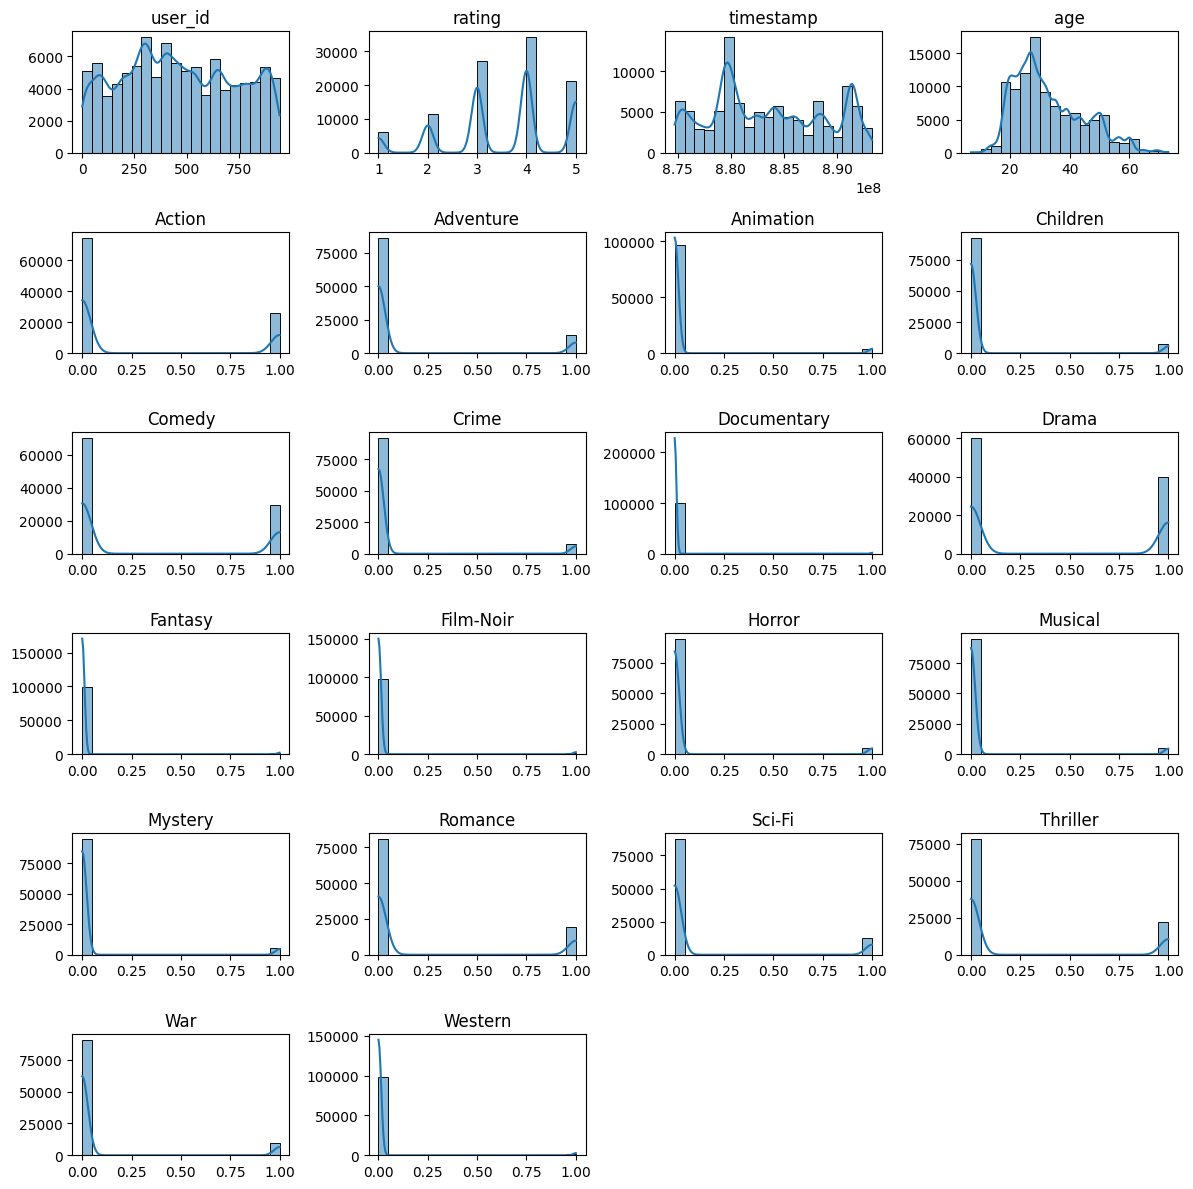

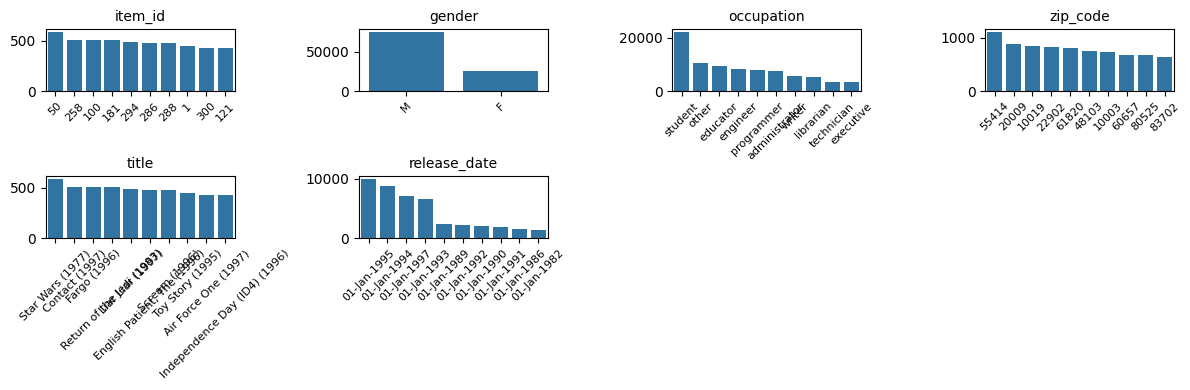

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Summary Statistics for ML-100k dataset, containing 100,000 movie ratings from 943 users on 1,682 movies.")

# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Plot numeric features
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

# Plot categorical features
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

**2. Datasets: ML-1M dataset** (Fine tuning is in progress)

All previous model files deleted in ./saved/
--2025-02-03 16:58:49--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./saved/ml-1m.zip’

./saved/ml-1m.zip   100%[===================>]   5.64M  5.96MB/s    in 0.9s    

2025-02-03 16:58:50 (5.96 MB/s) - ‘./saved/ml-1m.zip’ saved [5917549/5917549]

Dataset already extracted.

Sample data from the merged dataset:


,user_id,item_id,rating,timestamp,gender,age,occupation,zip_code,title,genres
907638,5492,648,5,2000-06-25 18:25:45,M,18,4,55104,Mission: Impossible (1996),Action|Adventure|Mystery
320379,1899,380,3,2000-11-21 03:30:58,F,45,6,02135,True Lies (1994),Action|Adventure|Comedy|Romance
226917,1377,736,5,2000-11-21 01:46:51,M,35,16,65270,Twister (1996),Action|Adventure|Romance|Thriller
943977,5693,111,5,2000-05-17 20:32:04,F,25,4,90034,Taxi Driver (1976),Drama|Thriller
27975,195,870,3,2001-03-01 04:30:53,M,25,12,10458,Gone Fishin' (1997),Comedy
565896,3475,1243,4,2002-03-10 05:29:33,M,25,14,33133,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama
705188,4227,1517,1,2000-08-03 16:26:06,M,25,19,11414-2520,Austin Powers: International Man of Mystery (1...,Comedy
64246,429,1345,3,2000-12-08 07:01:27,M,18,0,54901,Carrie (1976),Horror
563045,3464,296,5,2000-08-25 23:38:27,F,25,14,78251,Pulp Fiction (1994),Crime|Drama
421239,2544,2920,4,2001-12-11 03:37:36,M,45,1,52001,Children of Paradise (Les enfants du paradis) ...,Drama|Romance



Processed dataset saved at: ./saved/movielens_1m_processed.csv
Train size: 800167, Test size: 200042
Number of users in train set: 5400, Number of users in test set: 1783
Number of items in train set: 3662, Number of items in test set: 3511
Number of cold-start users (only in test set): 640
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 241s 782ms/step - loss: 7.6557 - sparse_categorical_accuracy: 1.8192e-04 - val_loss: 7.4465 - val_sparse_categorical_accuracy: 1.9531e-04
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step
User 0 - True: {'1252', '1704', '446', '1554', '2324', '326', '649', '608', '1961', '3111'}, Pred: ['2858', '1197', '1196', '1210', '110', '589', '593', '260', '1617', '1270']
User 1 - True: {'2396', '573', '1028', '750', '930', '3035', '300', '448', '290', '247', '2289', '935', '1537', '947', '1097', '649', '357', '3548', '527', '3037', '2762', '3363'}, Pred: ['2858', '1197', '1196', '1210', '110', '589', '593', '260', '1617', '1270']
User 2 - True: {'1252', '1111', '300', '247', '

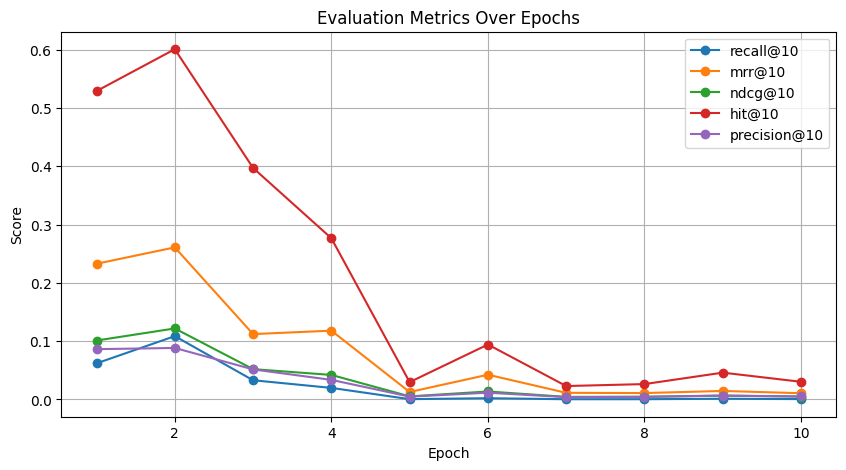

Training Completed! Metrics history saved to metrics_history.json


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

checkpoint_dir = "./saved/"
zip_path = "./saved/ml-1m.zip"
extract_path = "./saved/ml-1m/"

if os.path.exists(checkpoint_dir):
    for file in os.listdir(checkpoint_dir):
        file_path = os.path.join(checkpoint_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print(f"All previous model files deleted in {checkpoint_dir}")
else:
    os.makedirs(checkpoint_dir)

if not os.path.exists(zip_path):
    print("Downloading MovieLens 1M dataset...")
    !wget -O $zip_path "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
else:
    print("Dataset already downloaded.")

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    !unzip -o $zip_path -d $checkpoint_dir
else:
    print("Dataset already extracted.")

ratings_file = os.path.join(extract_path, "ratings.dat")
movies_file = os.path.join(extract_path, "movies.dat")
users_file = os.path.join(extract_path, "users.dat")

df = pd.read_csv(ratings_file, sep="::", names=['user_id', 'item_id', 'rating', 'timestamp'], engine="python")
movies = pd.read_csv(movies_file, sep="::", encoding="latin-1", header=None, engine="python",
                     names=['item_id', 'title', 'genres'])
users = pd.read_csv(users_file, sep="::", header=None, engine="python",
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on="user_id", how="left")
df = df.merge(movies, on="item_id", how="left")

print("\nSample data from the merged dataset:")
display(df.sample(10))  # Show 10 random rows

df.to_csv("./saved/movielens_1m_processed.csv", index=False)
print("\nProcessed dataset saved at: ./saved/movielens_1m_processed.csv")


df = df.sort_values(by=['timestamp'])

unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
# idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows()}
idx_to_title = {item_to_idx.get(row['item_id'], None): row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}


def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

# Identify cold-start users (users present only in test set)
cold_start_users = set(test_df['user_id']) - set(train_df['user_id'])
print(f"Number of cold-start users (only in test set): {len(cold_start_users)}")
train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 512

def mask_items(sequences, mask_prob=0.2):
    masked_sequences, labels = [], []
    for seq in sequences:
        masked_seq = seq[:]
        label = [-1] * len(seq)
        for i in range(len(seq)):
            if np.random.rand() < mask_prob:
                label[i] = masked_seq[i]
                masked_seq[i] = 0

        if all(l == -1 for l in label):
            random_idx = np.random.randint(len(seq))
            label[random_idx] = masked_seq[random_idx]
            masked_seq[random_idx] = 0

        label = [l if l != -1 else 0 for l in label]
        masked_seq = masked_seq[:max_seq_len] + [0] * (max_seq_len - len(masked_seq))
        label = label[:max_seq_len] + [0] * (max_seq_len - len(label))

        masked_sequences.append(masked_seq)
        labels.append(label)
    return np.array(masked_sequences, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = mask_items(train_sequences['item_id'].tolist())
test_input, test_labels = mask_items(test_sequences['item_id'].tolist())

class MaskedLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)


class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=128, num_layers=2, dropout_rate=0.2):
        super(xLSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.lstm_layers = [
            tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        for lstm_layer in self.lstm_layers:
            x = lstm_layer(x, training=training)
        logits = self.dense(x)
        return logits

model = xLSTM(vocab_size=len(item_to_idx) + 1, hidden_units=128, num_layers=2, dropout_rate=0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=MaskedLoss(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

def evaluate_metrics(model, test_input, test_labels, top_k=10):
    predictions = model.predict(test_input)
    logits = predictions[:, -1, :]  # Last position logits for all users
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    num_samples = len(test_labels)

    for i in range(num_samples):
        # Convert true item indices to actual item IDs
        true_items = set([idx_to_item[idx] for idx in np.where(test_labels[i] > 0)[0] if idx in idx_to_item])

        # Get top-K predictions, excluding seen items
        pred_items = [
            idx_to_item[int(idx)] for idx in np.argsort(logits[i])[::-1]
            if int(idx) in idx_to_item and idx not in true_items
        ][:top_k]

        pred_items_set = set(pred_items)

        # Debugging: Print actual values
        if i < 4:
            print(f"User {i} - True: {true_items}, Pred: {pred_items}")

        # Compute Metrics
        correct_preds = len(true_items & pred_items_set)
        recall += correct_preds / len(true_items) if len(true_items) > 0 else 0

        for rank, item in enumerate(pred_items, start=1):
            if item in true_items:
                mrr += 1 / rank
                break

        dcg = sum([(1 / np.log2(rank + 2)) if pred_items and pred_items[rank] in true_items else 0 for rank in range(min(len(pred_items), top_k))])
        idcg = sum([1 / np.log2(rank + 2) for rank in range(min(len(true_items), top_k))])
        ndcg += dcg / idcg if idcg > 0 else 0

        hit += int(correct_preds > 0) if pred_items else 0
        precision += correct_preds / top_k if pred_items else 0

    return recall / num_samples, mrr / num_samples, ndcg / num_samples, hit / num_samples, precision / num_samples

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=16, verbose=1)
    recall, mrr, ndcg, hit, precision = evaluate_metrics(model, test_input, test_labels)
    print(f"Metrics at epoch {epoch+1}:")
    print(f"Recall@10: {recall:.8f}, MRR@10: {mrr:.8f}, NDCG@10: {ndcg:.8f}, Hit@10: {hit:.8f}, Precision@10: {precision:.8f}")
    metrics_history["recall@10"].append(recall)
    metrics_history["mrr@10"].append(mrr)
    metrics_history["ndcg@10"].append(ndcg)
    metrics_history["hit@10"].append(hit)
    metrics_history["precision@10"].append(precision)
    print(metrics_history)

def recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    top_indices = [idx for idx in np.argsort(logits)[::-1] if idx not in watched_items_set][:top_k]

    print(f"Top Recommended Items for User ID {user_id}:")
    recommended_items = []

    for i, idx in enumerate(top_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return recommended_items

def least_recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    bottom_indices = [idx for idx in np.argsort(logits) if idx not in watched_items_set][:top_k]

    print(f"Least Recommended Items for User ID {user_id}:")
    least_recommended_items = []

    for i, idx in enumerate(bottom_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            least_recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return least_recommended_items

recommend_items(user_id=1, top_k=10)
print("  ")
recommend_items(user_id=2, top_k=10)

import matplotlib.pyplot as plt

# Plot the metrics over epochs
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

import json

# Save metrics history to a JSON file
with open("metrics_history.json", "w") as f:
    json.dump(metrics_history, f, indent=4)

print("Training Completed! Metrics history saved to metrics_history.json")


Summary Statistics for MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.


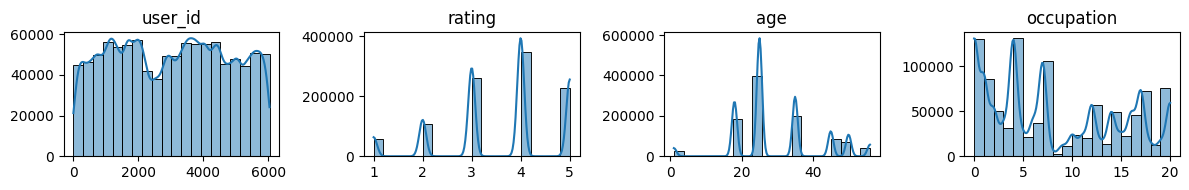

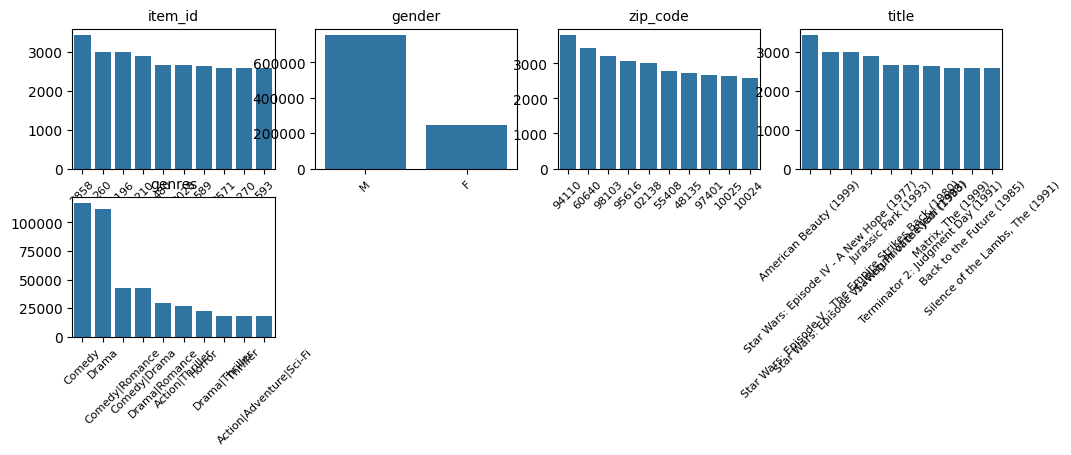

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Summary Statistics for MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.")

# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Plot numeric features
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

# Plot categorical features
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
!pip install recbole ray kmeans_pytorch optuna wandb surprise

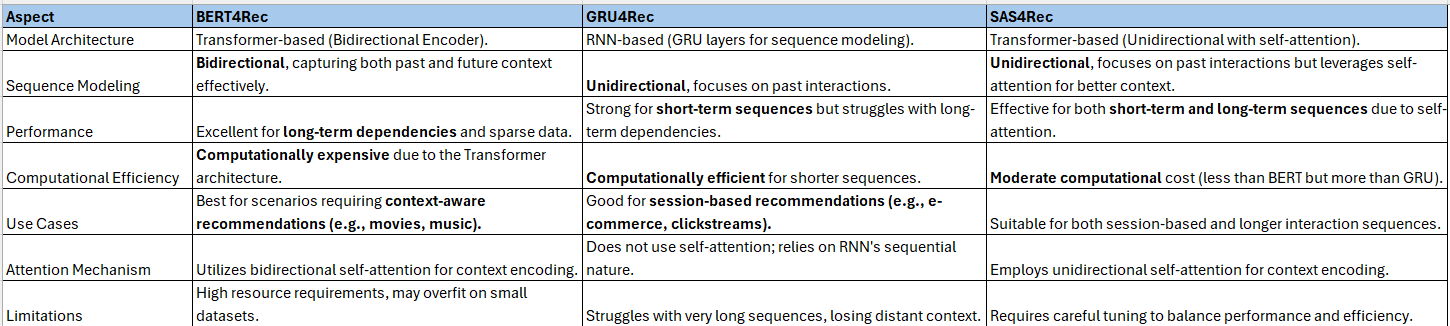